In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/Users/yaoli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using device: cpu


In [2]:
# Transform: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean & std
])

# Download datasets
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████| 9912422/9912422 [01:03<00:00, 155810.71it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 214419.57it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████| 1648877/1648877 [00:15<00:00, 106192.85it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1895763.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # MNIST is 28x28 → 7x7 after pooling twice
        self.fc2 = nn.Linear(128, 10)  # 10 classes (digits 0-9)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100 * correct / len(test_loader.dataset)
    
    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {epoch_loss:.4f}, "
        f"Test Loss: {test_loss:.4f}, "
        f"Accuracy: {accuracy:.2f}%"
    )

Epoch 1/10, Train Loss: 0.1692, Test Loss: 0.0400, Accuracy: 98.73%
Epoch 2/10, Train Loss: 0.0642, Test Loss: 0.0329, Accuracy: 98.99%
Epoch 3/10, Train Loss: 0.0491, Test Loss: 0.0242, Accuracy: 99.24%
Epoch 4/10, Train Loss: 0.0378, Test Loss: 0.0232, Accuracy: 99.22%
Epoch 5/10, Train Loss: 0.0326, Test Loss: 0.0305, Accuracy: 99.16%
Epoch 6/10, Train Loss: 0.0284, Test Loss: 0.0271, Accuracy: 99.19%
Epoch 7/10, Train Loss: 0.0265, Test Loss: 0.0247, Accuracy: 99.25%
Epoch 8/10, Train Loss: 0.0219, Test Loss: 0.0238, Accuracy: 99.25%
Epoch 9/10, Train Loss: 0.0204, Test Loss: 0.0234, Accuracy: 99.28%
Epoch 10/10, Train Loss: 0.0180, Test Loss: 0.0247, Accuracy: 99.28%


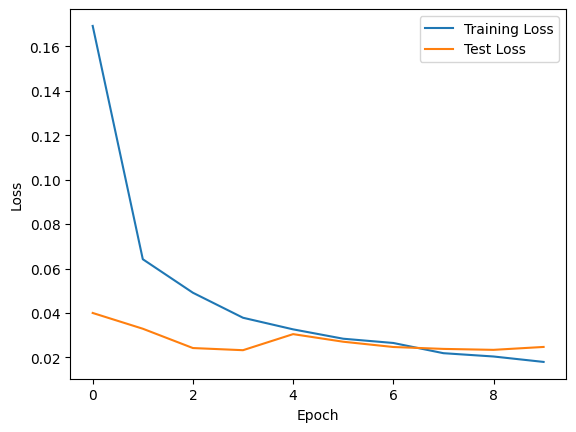

In [9]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# 练习
本次上机作业需要在模型中加入残差模块或自注意力模块